# Assignment 7.3 Hotel Recommendations

Name: Allyson Busch

Course: DSC 630

Data: Kaggle Expedia Hotel Recommendations Data containing four files: train.csv, test.csv, destinations.csv, and sample_submission.csv

In [1]:
# importing libraries

import pandas as pd
import seaborn as sns
import numpy as np
import warnings
import matplotlib.pyplot as plt

# other imports

from datetime import datetime
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipelin 9e
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

warnings.simplefilter('ignore')

In [2]:
# LOADING DATA
# loading training data 

train = pd.read_csv('train.csv', nrows = 100000)

# loading test data

test = pd.read_csv('test.csv', nrows = 100000)

# loading destination data 

destination = pd.read_csv('destinations.csv', nrows = 100000)

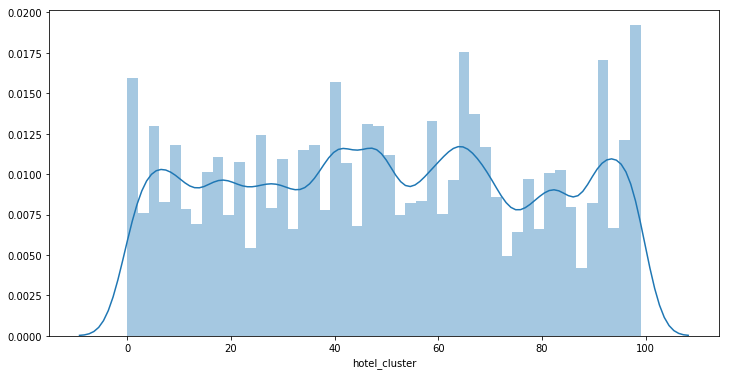

In [3]:
# histogram of clusters
plt.figure(figsize=(12,6))
sns.distplot(train['hotel_cluster'])

According to the above histograb, data is well distributed over the clusters.

In [4]:
# extracting year from data 

def extract_year(x):
    '''
    Args:
        datetime
    Returns:
        year as numeric
    '''
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

# extracting month from data 

def extract_month(x):
    '''
    Args:
        datetime
    Returns:
        month as numeric
    '''    
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass

In [5]:
# extracting the year and month from date time column
train['date_time_year'] = pd.Series(train.date_time, index = train.index)
train['date_time_month'] = pd.Series(train.date_time, index = train.index)

train.date_time_year = train.date_time_year.apply(lambda x: extract_year(x))
train.date_time_month = train.date_time_month.apply(lambda x: extract_month(x))
del train['date_time']

In [6]:
# repeating with check in date column 
train['srch_ci_year'] = pd.Series(train.srch_ci, index = train.index)
train['srch_ci_month'] = pd.Series(train.srch_ci, index = train.index)

train.srch_ci_year = train.srch_ci_year.apply(lambda x: extract_year(x))
train.srch_ci_month = train.srch_ci_month.apply(lambda x: extract_month(x))
del train['srch_ci']

In [7]:
# repeating with check out date column 
train['srch_co_year'] = pd.Series(train.srch_co, index = train.index)
train['srch_co_month'] = pd.Series(train.srch_co, index = train.index)

train.srch_co_year = train.srch_co_year.apply(lambda x: extract_year(x))
train.srch_co_month = train.srch_co_month.apply(lambda x: extract_month(x))
del train['srch_co']

In [8]:
train.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,8
1,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,9
2,2,3,66,348,48862,2234.2641,12,0,0,9,...,2,50,628,1,2014,8,2014,8,2014,9
3,2,3,66,442,35390,913.1932,93,0,0,3,...,2,50,1457,80,2014,8,2014,11,2014,11
4,2,3,66,442,35390,913.6259,93,0,0,3,...,2,50,1457,21,2014,8,2014,11,2014,11


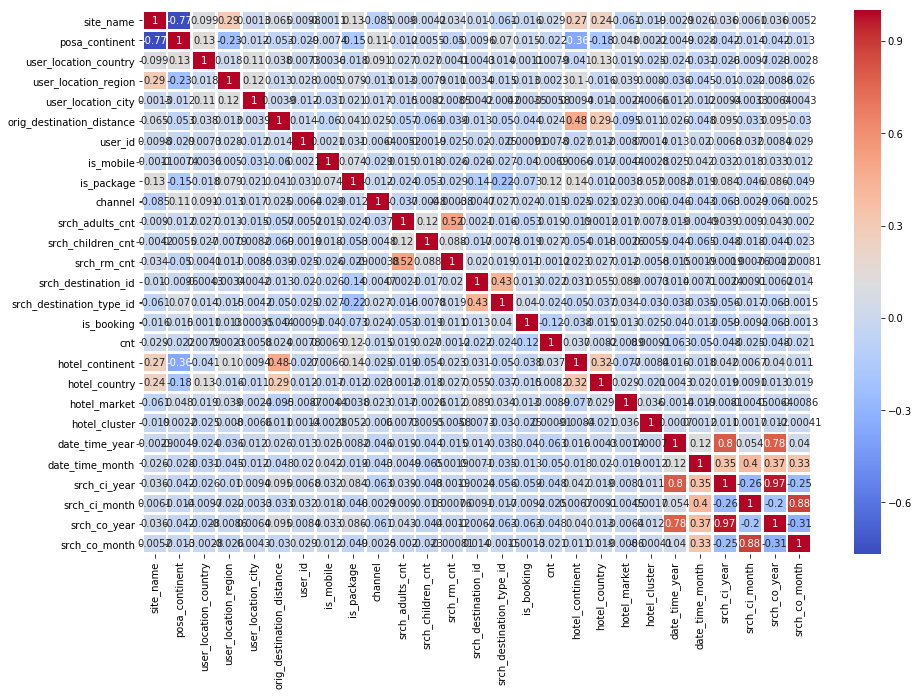

In [9]:
# exploring the data set 

# evaluating correlations of dataset

fig, ax = plt.subplots()
fig.set_size_inches(15,10)
sns.heatmap(train.corr(), cmap='coolwarm', ax = ax, annot=True, linewidths = 2)

In [11]:
train.corr()["hotel_cluster"].sort_values()

srch_destination_type_id    -0.030064
is_booking                  -0.025380
user_location_country       -0.025170
hotel_country               -0.021170
site_name                   -0.019154
hotel_continent             -0.008441
srch_destination_id         -0.007258
user_location_city          -0.006580
channel                     -0.005956
srch_rm_cnt                 -0.005801
is_mobile                   -0.002803
srch_co_month               -0.000413
date_time_year               0.000696
cnt                          0.000914
date_time_month              0.001208
user_id                      0.001396
srch_ci_month                0.001682
posa_continent               0.002204
srch_children_cnt            0.005469
srch_adults_cnt              0.007322
user_location_region         0.008037
srch_ci_year                 0.010879
orig_destination_distance    0.011362
srch_co_year                 0.012014
hotel_market                 0.036107
is_package                   0.051955
hotel_cluste

According to the correlation above, there is no true strong relationship between hotel_cluster and the other variables which means linear models may not be the best. 

In [12]:
train_book = train.loc[train['is_booking'] == 1]

In [13]:
# grouping data

factors = [train_book.groupby(['srch_destination_id','hotel_country','hotel_market','is_package','hotel_cluster'])['is_booking'].agg(['sum','count'])]
summ = pd.concat(factors).groupby(level=[0,1,2,3,4]).sum()
summ.dropna(inplace=True)
summ.head()

sum  \
srch_destination_id hotel_country hotel_market is_package hotel_cluster        
8                   50            416          0          32               1   
                                                          77               1   
11                  50            824          0          94               1   
14                  27            1434         0          20               1   
16                  50            419          0          7                1   

                                                                         count  
srch_destination_id hotel_country hotel_market is_package hotel_cluster         
8                   50            416          0          32                 1  
                                                          77                 1  
11                  50            824          0          94                 1  
14                  27            1434         0          20                 1  
16                  50            419          0          7                  1

In [14]:
summ['sum_and_cnt'] = 0.85*summ['sum'] + 0.15*summ['count']
summ = summ.groupby(level=[0,1,2,3]).apply(lambda x: x.astype(float)/x.sum())
summ.reset_index(inplace=True)
summ.head()

,srch_destination_id,hotel_country,hotel_market,is_package,hotel_cluster,sum,count,sum_and_cnt
0,8,50,416,0,32,0.5,0.5,0.5
1,8,50,416,0,77,0.5,0.5,0.5
2,11,50,824,0,94,1.0,1.0,1.0
3,14,27,1434,0,20,1.0,1.0,1.0
4,16,50,419,0,7,1.0,1.0,1.0


In [15]:
summ_pivot = summ.pivot_table(index=['srch_destination_id','hotel_country','hotel_market','is_package'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
summ_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,is_package,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,50,824,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,14,27,1434,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,50,419,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,77,1454,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
destination.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [17]:
train_book = pd.merge(train_book, destination, how='left', on='srch_destination_id')
train_book = pd.merge(train_book, summ_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market','is_package'])
train_book.fillna(0, inplace=True)
train_book.shape

(8270, 276)

In [18]:
# seperating the target variable and predictor variables
X = train_book.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = train_book.hotel_cluster
X.shape, y.shape

((8270, 273), (8270,))

In [19]:
# checking to see if 100 clusters are present
y.nunique()

100

In [20]:
# SUPPORT VECTOR MACHINE (SVM)

classifier = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(classifier, X, y, cv=10))

0.44068991421877335

In [21]:
# K-Nearest Neighbor (KNN) Classifier

classifier = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(classifier, X, y, cv=10, scoring='accuracy'))

0.38058519319445827

In [22]:
# Logistic Regression

classifier = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(classifier, X, y, cv=10))

0.3850620429664882

In [ ]:
# Naive Bayes Classifier 

classifier = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(classifier, X, y, cv=10))

The SVM algorithm performed the best of the above algorithms, but the cross validation score is only 0.44. 